Montamos la unidad de drive

In [12]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
# Instalar librería para pinitar mapa
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

In [0]:
import pandas as pd

files_path = "/content/drive/My Drive/CVBLab/HARVIS_UC2/BBDD/FR1193_Toulouse_Seville/"
metar1_path = 'metar1_guay.csv'  # Archivo con info metar1 - metar 30 minutos antes de aterrizaje
metar2_path = 'metar2_guay.csv'  # Archivo con info metar2 - metar en momento de aterrizaje
traj_path = 'trajectories.csv' # Archivo con datos de trayectoria con padding
gt_path = 'gt_data.csv'      # Archivo con información de Ground Truth (Clasificación)

traj = pd.read_csv(files_path + traj_path, sep=",")
gt = pd.read_csv(files_path + gt_path, sep=",")


In [0]:
traj

In [0]:
gt

### Tratamiento datos de salida (Ground-Truth)

Leemos los datos de salida posibles y los pasamos a numérico y a one-hot-encoding

In [0]:
import numpy as np
from keras.utils import to_categorical

gt_labels = ['Rotex','Santa']
gt_num = []

for flight_id, name in zip(gt['Flight_id'], gt['gt_label']):
  fl_id = flight_id.split('_')[-1]
  label = 0
  for j in gt_labels:
    if name == j:
      gt_num.append([fl_id ,label])
    label += 1

# One-Hot-Encoding
y_gt = np.array(to_categorical([item[-1] for item in gt_num]))

print(y_gt)

### Tratamiento datos de trayectoria

Pasamos las variables a formato float y nos quedamos los datos

In [16]:
import re
variables = ['hour', 'minute', 'second', 'altitude', 'direction', 'latitude', 'longitude', 'speed']
for v in variables:
  n = 0
  for i in traj[v]:  
    result = re.search('\[(.*)\]', i)
    traj[v][n] = [float(j) for j in result.group(1).split(',')]
    n +=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
# Separar una serie de datos secuenciales univariante en muestras diferentes y la salida
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps # Fin de secuencia
		if end_ix > len(sequence)-1: # Comprobar si hemos rebasado el final
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # Separar entre entrada y salida
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [0]:
import numpy as np
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [0]:
# Normalizamos los datos de trayectoria respecto de los máximos y mínimos (no siguen una distribución gaussiana)

def normalize_data(x_data, min_value, max_value):
  # Normalizamos datos de entrada entre un mínimo y máximo para obtener un valor entre 0 y 1
  # x_data tiene shape = (samples, timestemps)
  x_norm = np.zeros(x_data.shape)
  x_norm = (x_data-min_value)/(max_value-min_value)

  return x_norm


def denormalize_data(norm_data, min_value, max_value):
  # Normalizamos datos de entrada entre un mínimo y máximo para obtener un valor entre 0 y 1
  # x_data tiene shape = (samples, timestemps)
  x_data = np.zeros(norm_data.shape)
  x_data = (norm_data*(max_value-min_value))+min_value

  return x_data

### Univariate LSTM

In [0]:
# univariate lstm example
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

n_steps = 10
n_features = 1 

X, Y = np.zeros([0,n_steps]), np.zeros([0,n_steps])

for i in range(len(traj)):
  data = normalize_data(np.array(traj['altitude'][i]), 0, 40000)
  x1, y1 = split_sequence(data, n_steps)
  X = np.insert(X, len(X), x1, axis=0)
  Y = np.append(Y, y1)

# Reshape para introducri en red LSTM
X = X.reshape(X.shape[0],X.shape[1],n_features) # samples-timesteps-features


# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, Y, epochs=20, batch_size=100, verbose=1)


In [0]:
# demonstrate prediction
k = 106 # Medida a predecir
x_input = normalize_data(np.array(traj['altitude'][0][k-10:k]), 0, 40000)
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print('- Predicted: {}\n- Real: {}'.format(denormalize_data(yhat, 0, 40000)[0][0], traj['altitude'][0][k]))

- Predicted: 24286.35546875
- Real: 24800.0


### Multivariate LSTM

Creamos 2 redes LSTM, una para cada posible trayectoria

In [0]:
## Hiperparámetros
n_steps = 20 # Timesamples a tener en cuenta por a red LSTM para predecir
n_features = 3 
epochs = 25
batch_size = 50 
validation_split = 0.2

In [21]:
### Red-LSTM 1: trayectorias por y_gt = 0 = ROTEX

# multivariate output stacked lstm example
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import SGD
import matplotlib.pyplot as plt
 

# Formato deseado: (samples-timesteps-features)
X1 = np.zeros([0, n_steps, n_features])
Y1 = np.zeros([0,n_features])

traj1 = np.where(np.argmax(y_gt, axis=1)==0) # Trayectorias que pasan por Rotex

for i in traj1[0]:
	# define input sequence
	in_seq1 = normalize_data(np.array(traj['altitude'][i]), 0, 40000)
	in_seq2 = normalize_data(np.array(traj['latitude'][i]), 35,45)
	in_seq3 = normalize_data(np.array(traj['longitude'][i]), -10, 3)
	
	# convert to [rows, columns] structure
	in_seq1 = in_seq1.reshape((len(in_seq1), 1))
	in_seq2 = in_seq2.reshape((len(in_seq2), 1))
	in_seq3 = in_seq3.reshape((len(in_seq3), 1))
 
	# horizontally stack columns
	sample_dataset = np.hstack((in_seq1, in_seq2, in_seq3))
	# convert into input/output
	x, y = split_sequences(sample_dataset, n_steps)
	X1 = np.insert(X1, len(X1), x, axis=0) # añadimos en última posición
	Y1 = np.insert(Y1, len(Y1), y, axis=0)
 
# define model
model1 = Sequential()
model1.add(LSTM(50, activation='linear', return_sequences=False, input_shape=(n_steps, n_features)))
model1.add(Dense(n_features))

model1.compile('adam',loss='mse',metrics=["mse"])
# fit model
H1 = model1.fit(X1, Y1, epochs=epochs, verbose=1, batch_size=batch_size, validation_split=validation_split)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 18260 samples, validate on 4565 samples
Epoch 1/25





18260/18260 [==============================] - 9s 483us/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 7.2285e-04 - val_mean_squared_error: 7.2285e-04
Epoch 2/25
18260/18260 [==============================] - 7s 405us/step - loss: 6.0008e-04 - mean_squared_error: 6.0008e-04 - val_loss: 3.6828e-04 - val_mean_squared_error: 3.6828e-04
Epoch 3/25
18260/18260 [==============================] - 7s 404us/step - loss: 3.3926e-04 - mean_squared_error: 3.3926e-04 - val_loss: 2.4950e-04 - val_mean_squared_error: 2.4950e-04
Epoch 4/25
 9500/18260 [==============>...............] - ETA: 3s - loss: 2.7421e-04 - mean_squared_error: 2.7421e-04

KeyboardInterrupt: ignored

In [0]:
### Red-LSTM 2: trayectorias por y_gt = 0 = SANTA

# Formato deseado: (samples-timesteps-features)
X2 = np.zeros([0, n_steps, n_features])
Y2 = np.zeros([0,n_features])

traj2 = np.where(np.argmax(y_gt, axis=1)==1) # Trayectorias que pasan por Santa

for i in traj2[0]:
	# define input sequence
	in_seq1 = normalize_data(np.array(traj['altitude'][i]), 0, 40000) # Entrenamos sólo sobre últimos puntos de la trayectoria [-100:]
	in_seq2 = normalize_data(np.array(traj['latitude'][i]), 35,45)
	in_seq3 = normalize_data(np.array(traj['longitude'][i]), -10, 3)
	
	# convert to [rows, columns] structure
	in_seq1 = in_seq1.reshape((len(in_seq1), 1))
	in_seq2 = in_seq2.reshape((len(in_seq2), 1))
	in_seq3 = in_seq3.reshape((len(in_seq3), 1))
 
	# horizontally stack columns
	sample_dataset = np.hstack((in_seq1, in_seq2, in_seq3))
	# convert into input/output
	x, y = split_sequences(sample_dataset, n_steps)
	X2 = np.insert(X2, len(X2), x, axis=0) # añadimos en última posición
	Y2 = np.insert(Y2, len(Y2), y, axis=0)
 
# define model
model2 = Sequential()
model2.add(LSTM(50, activation='linear', return_sequences=False, input_shape=(n_steps, n_features)))
model2.add(Dense(n_features))

model2.compile('adam', loss='mse', metrics=["mse"])
# fit model
H2 = model2.fit(X2, Y2, epochs=epochs, verbose=1, batch_size=batch_size, validation_split=0.2)



Train on 8193 samples, validate on 2049 samples
Epoch 1/25
8193/8193 [==============================] - 4s 484us/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/25
8193/8193 [==============================] - 3s 372us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 8.9344e-04 - val_mean_squared_error: 8.9344e-04
Epoch 3/25
8193/8193 [==============================] - 3s 375us/step - loss: 8.6485e-04 - mean_squared_error: 8.6485e-04 - val_loss: 6.9066e-04 - val_mean_squared_error: 6.9066e-04
Epoch 4/25
8193/8193 [==============================] - 3s 401us/step - loss: 6.4172e-04 - mean_squared_error: 6.4172e-04 - val_loss: 4.8730e-04 - val_mean_squared_error: 4.8730e-04
Epoch 5/25
8193/8193 [==============================] - 3s 379us/step - loss: 5.0999e-04 - mean_squared_error: 5.0999e-04 - val_loss: 3.8477e-04 - val_mean_squared_error: 3.8477e-04
Epoch 6/25
8193/8193 [==============================] - 3s 383us/s

In [0]:
# demonstrate prediction

from tabulate import tabulate

k = 77 # Medida a predecir
# define input sequence
in_seq1 = normalize_data(np.array(traj['altitude'][77][k-n_steps:k]), 0, 40000)
in_seq2 = normalize_data(np.array(traj['latitude'][77][k-n_steps:k]), 35,45)
in_seq3 = normalize_data(np.array(traj['longitude'][77][k-n_steps:k]), -10, 3)
# convert to [rows, columns] structure
dataset= np.array([in_seq1, in_seq2, in_seq3])
x_input = dataset.reshape((1, n_steps, n_features))
yhat = model1.predict(x_input, verbose=0)
pred_altitude= denormalize_data(yhat[0,0], 0, 40000)
pred_latitude= denormalize_data(yhat[0,1], 35, 45)
pred_longitude= denormalize_data(yhat[0,2], -10, 3)


print(tabulate([['Predicted', pred_altitude, pred_latitude, pred_longitude], ['Real', traj['altitude'][0][k], traj['latitude'][0][k], traj['longitude'][0][k]]], headers=['','Altitude', 'Latitude', 'Longitude']))

             Altitude    Latitude    Longitude
---------  ----------  ----------  -----------
Predicted     23435.3     41.1212     -2.29677
Real          31000       41.0604     -2.29718


### Pruebas

In [0]:
tr_id = 155
last_measure = -90

pred_lat, pred_lon, pred_alt = list(), list(), list()

input_alt = normalize_data(np.array(traj['altitude'][tr_id][last_measure-n_steps:last_measure]), 0, 40000)
input_lat = normalize_data(np.array(traj['latitude'][tr_id][last_measure-n_steps:last_measure]), 35, 45)
input_lon = normalize_data(np.array(traj['longitude'][tr_id][last_measure-n_steps:last_measure]), -10, 3)

dataset= np.array([input_alt, input_lat, input_lon])
x_input = dataset.reshape((1, n_steps, n_features))

# models = [model1, model2]
# model = models[pred_mlp]
# Elejimos el modelo según la trayectoria
if tr_id in traj1[0]: model = model1
elif tr_id in traj2[0]: model = model2

for i in range(abs(last_measure)):
  yhat = model.predict(x_input, verbose=0)

  pred_alt.append(denormalize_data(yhat[0,0], 0, 40000))
  pred_lat.append(denormalize_data(yhat[0,1], 35, 45))
  pred_lon.append(denormalize_data(yhat[0,2], -10, 3))

  x_input = np.vstack([x_input[0], yhat[0]])[1:]
  x_input = x_input.reshape((1, n_steps, n_features))


output_alt = np.concatenate([np.array(traj['altitude'][tr_id][:last_measure]), pred_alt])
output_lat = np.concatenate([np.array(traj['latitude'][tr_id][:last_measure]), pred_lat])
output_lon = np.concatenate([np.array(traj['longitude'][tr_id][:last_measure]), pred_lon])
                     


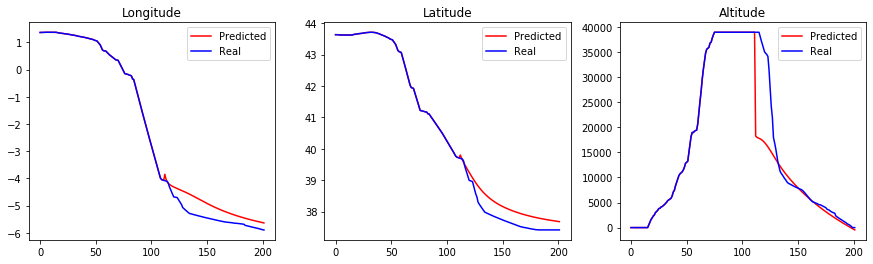

In [0]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131)

labels = ['Predicted', 'Real']

ax.title.set_text('Longitude')
ax.plot(output_lon, 'r')
ax.plot(traj['longitude'][tr_id], 'b')
ax.legend(labels)

ax = fig.add_subplot(132)
ax.title.set_text('Latitude')
ax.plot(output_lat, 'r')
ax.plot(traj['latitude'][tr_id], 'b')
ax.legend(labels)

ax = fig.add_subplot(133)
ax.title.set_text('Altitude')
ax.plot(output_alt, 'r')
ax.plot(traj['altitude'][tr_id], 'b')
ax.legend(labels)


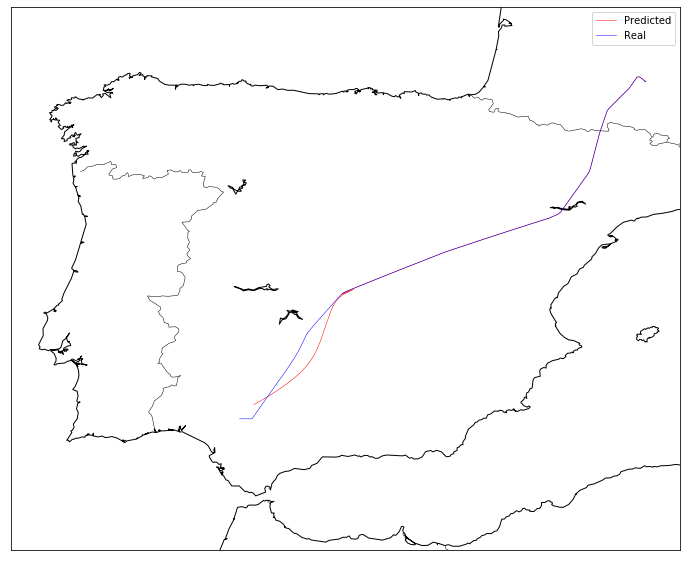

In [0]:
from mpl_toolkits.basemap import Basemap

BBox = [-10, 2, 35, 45] # Longitud (min-max) y latitud (min-max)

fig = plt.figure(figsize=((BBox[1]-BBox[0]), BBox[3]-BBox[2]))
ax = fig.add_subplot(111)

ax.set_xlim((BBox[0], BBox[1]))
ax.set_ylim((BBox[2], BBox[3]))

m = Basemap(resolution='i', llcrnrlon=BBox[0], llcrnrlat=BBox[2], urcrnrlon=BBox[1], urcrnrlat=BBox[3], fix_aspect=False)
m.drawcoastlines()
m.drawcountries()

ax.plot(output_lon, output_lat, linewidth=0.5, c='r')
ax.plot(traj['longitude'][tr_id], traj['latitude'][tr_id], linewidth=0.5, c='b')

ax.legend(labels)
